In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm

import tensorflow as tf

import os
import shutil
from tqdm import tqdm
from random import shuffle

import cv2
from glob import glob

from tensorflow.keras import backend as K
import random

from sklearn.model_selection import train_test_split, StratifiedKFold

from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.efficientnet import *
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

In [2]:
image_dir = Path('/content/drive/MyDrive/flowers')
filepaths=list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths=pd.Series(filepaths,name='Filepath').astype(str)
labels=pd.Series(labels,name='Label')
image_df = pd.concat([filepaths, labels], axis=1)

In [4]:
image_dir

PosixPath('/content/drive/MyDrive/flowers')

In [5]:
image_df.head()

,Filepath,Label
0,/content/drive/MyDrive/flowers/tulip/100930342...,tulip
1,/content/drive/MyDrive/flowers/tulip/109959539...,tulip
2,/content/drive/MyDrive/flowers/tulip/100947296...,tulip
3,/content/drive/MyDrive/flowers/tulip/101285468...,tulip
4,/content/drive/MyDrive/flowers/tulip/100947311...,tulip


In [6]:
image_df = image_df.sample(frac=1).reset_index(drop = True)
image_df.head(12)

,Filepath,Label
0,/content/drive/MyDrive/flowers/daisy/346115659...,daisy
1,/content/drive/MyDrive/flowers/tulip/704269284...,tulip
2,/content/drive/MyDrive/flowers/dandelion/22785...,dandelion
3,/content/drive/MyDrive/flowers/tulip/693174825...,tulip
4,/content/drive/MyDrive/flowers/rose/1786984657...,rose
5,/content/drive/MyDrive/flowers/tulip/152751907...,tulip
6,/content/drive/MyDrive/flowers/sunflower/11881...,sunflower
7,/content/drive/MyDrive/flowers/daisy/949620971...,daisy
8,/content/drive/MyDrive/flowers/rose/3621011057...,rose
9,/content/drive/MyDrive/flowers/tulip/744845376...,tulip


In [7]:
image_df.shape

(4996, 2)

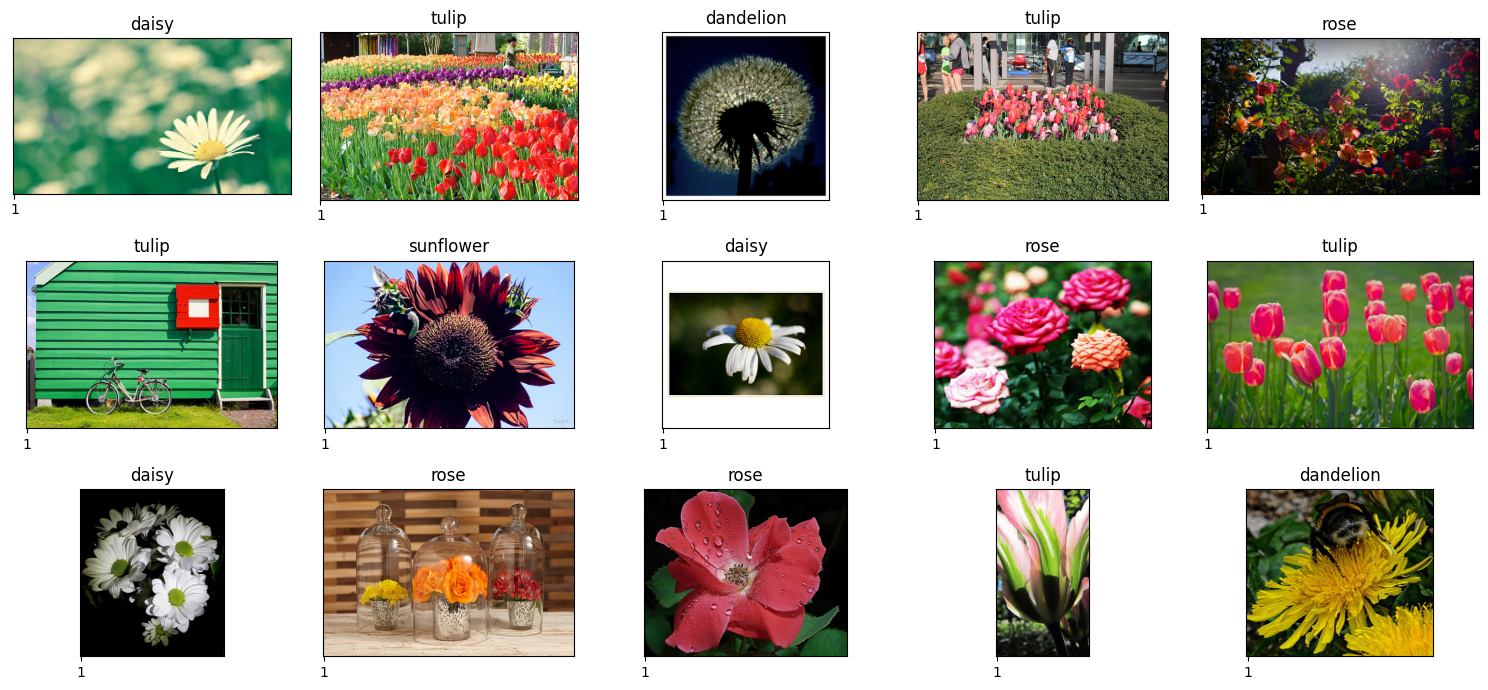

In [8]:
fig,axes=plt.subplots(nrows=3,ncols=5,figsize=(15,7),subplot_kw={'xticks':[1],'yticks':[]})


for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()



In [10]:
train_df ,test_df = train_test_split(image_df, train_size=0.8, shuffle=True, random_state=1)

In [11]:
train_df.shape

(3996, 2)

In [13]:
test_df.shape

(1000, 2)

In [14]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [15]:
train_df.head()

,Filepath,Label
187,/content/drive/MyDrive/flowers/rose/5001852101...,rose
1132,/content/drive/MyDrive/flowers/tulip/183785819...,tulip
1523,/content/drive/MyDrive/flowers/daisy/342954448...,daisy
4829,/content/drive/MyDrive/flowers/rose/1998840679...,rose
453,/content/drive/MyDrive/flowers/dandelion/14053...,dandelion


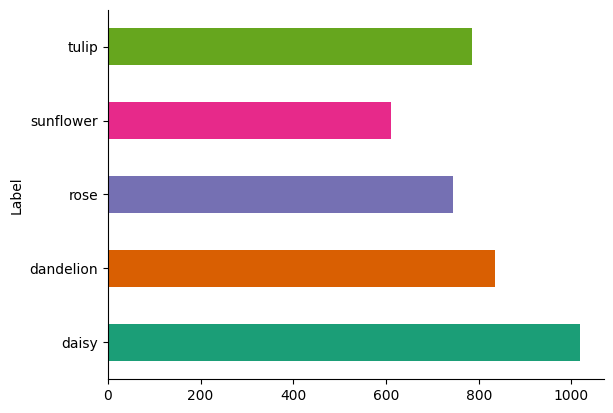

In [16]:
# @title Label

from matplotlib import pyplot as plt
import seaborn as sns
train_df.groupby('Label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [17]:
train_df.tail()

,Filepath,Label
2895,/content/drive/MyDrive/flowers/sunflower/25752...,sunflower
2763,/content/drive/MyDrive/flowers/rose/8671682526...,rose
905,/content/drive/MyDrive/flowers/dandelion/14065...,dandelion
3980,/content/drive/MyDrive/flowers/daisy/347587014...,daisy
235,/content/drive/MyDrive/flowers/tulip/565336430...,tulip


In [18]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3197 validated image filenames belonging to 5 classes.
Found 799 validated image filenames belonging to 5 classes.
Found 1000 validated image filenames belonging to 5 classes.


In [19]:
def create_model(input_shape=(224, 224, 3)):

    inputs = Input(input_shape)
    base_model = EfficientNetB1(input_shape=input_shape, include_top=False, classes=5)

    x = base_model(inputs)

    x = GlobalAveragePooling2D()(x)
#     x = Dropout(0.1)(x)

    x = Dense(56, activation='relu')(x)
    x = Dropout(0.1)(x)

    outputs = Dense(5, activation='sigmoid')(x)

    model = Model(inputs, outputs)

    return model
K.clear_session()

model = create_model((224, 224, 3))
# model = load_model('models/checkpoint/EfficientNetB0.h5')

metrics = [
    'accuracy',
    'AUC'
]

27018416/27018416 [==============================] - 0s 0us/step


In [20]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=metrics)

In [21]:
checkpoint_path = 'models/EfficientNetB1/model_224.keras'

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=15, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False)
]

In [ ]:
%%time
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
  8/100 [=>............................] - ETA: 21:51 - loss: 1.2182 - accuracy: 0.5059 - auc: 0.7586

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:

results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()